# MobileBERT Evaluation for Fake News Detection

## Introduction

This notebook evaluates our fine-tuned MobileBERT model for fake news detection. MobileBERT is a compressed, pre-trained BERT model that has been specifically optimized for mobile and edge devices. It uses techniques like bottleneck structures, knowledge distillation, and other architectural optimizations to achieve a model that maintains BERT's performance while being significantly faster and more efficient. These characteristics make it an excellent candidate for deployment in environments with limited computational resources.

We'll perform a comprehensive evaluation focusing on:

1. Performance on the WELFake test dataset
2. Generalization capabilities when tested on external datasets containing verified real news and AI-generated fake news
3. Resource efficiency metrics critical for edge device deployment:
   - Memory footprint
   - Inference speed
   - Batch processing efficiency
   - Sequence length impact

The goal is to determine if mobile-optimized transformer models like MobileBERT can effectively detect fake news while meeting the practical constraints of resource-limited environments.

## Setting Up the Environment

First, we'll import the necessary libraries for our evaluation:

In [1]:
# Import basic libraries for data manipulation and visualization
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time
import os
import psutil
import gc

In [2]:
# Import PyTorch and transformers
import torch
from torch.utils.data import DataLoader, TensorDataset
from transformers import AutoTokenizer, AutoModelForSequenceClassification

In [3]:
# Import evaluation metrics
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split

In [4]:
# Improved memory measurement function
def measure_peak_memory_usage(func, *args, **kwargs):
    """
    Measure peak memory usage during function execution
    
    Args:
        func: Function to measure
        *args, **kwargs: Arguments to pass to the function
        
    Returns:
        Tuple of (function result, peak memory usage in MB)
    """
    # Reset garbage collection and force collection before starting
    gc.collect()
    
    # Start tracking
    process = psutil.Process()
    start_memory = process.memory_info().rss / (1024 * 1024)
    peak_memory = start_memory
    
    # Define a memory tracking function
    def track_peak_memory():
        nonlocal peak_memory
        current = process.memory_info().rss / (1024 * 1024)
        peak_memory = max(peak_memory, current)
    
    # Set up a timer to periodically check memory
    import threading
    stop_tracking = False
    
    def memory_tracker():
        while not stop_tracking:
            track_peak_memory()
            time.sleep(0.1)
    
    # Start tracking thread
    tracking_thread = threading.Thread(target=memory_tracker)
    tracking_thread.daemon = True
    tracking_thread.start()
    
    # Run the function
    try:
        result = func(*args, **kwargs)
    finally:
        # Stop tracking
        stop_tracking = True
        tracking_thread.join(timeout=1.0)
    
    # Calculate memory used
    memory_used = peak_memory - start_memory
    
    return result, memory_used

In [5]:
# Suppress warnings and set visualization style
import warnings
warnings.filterwarnings('ignore')

# Set consistent visualization style
plt.style.use('ggplot')
sns.set(font_scale=1.2)
plt.rcParams['figure.figsize'] = (10, 6)

# Force CPU usage to simulate edge device performance
device = torch.device("cpu")
print(f"Using device: {device} (simulating edge device performance)")

Using device: cpu (simulating edge device performance)


## Loading Data

### WELFake Test Set

We'll first load the WELFake dataset, which contains a balanced collection of real and fake news articles. This dataset combines articles from multiple sources: PolitiFact, GossipCop, Reuters, and BuzzFeed.

In [6]:
# Load the WELFake dataset
df = pd.read_csv('../../data/WELFake_cleaned.csv')

# Combine title and text to provide complete information to the model
df['combined_text'] = df['title'] + " " + df['text']

# Prepare features and labels
X_welfake = df['combined_text']
y_welfake = df['label']

In [7]:
# Split into train and test sets with stratification to maintain class balance
X_train, X_test, y_train, y_test = train_test_split(
    X_welfake, y_welfake, test_size=0.2, random_state=42, stratify=y_welfake
)

print(f"WELFake test set: {len(X_test)} articles")

WELFake test set: 14308 articles


### External Datasets

To evaluate the model's generalization capabilities, we'll also test it on external datasets containing news articles not seen during training. This helps assess how well the model performs on real-world content.

In [8]:
# Load external datasets
real_df = pd.read_csv('../datasets/manual_real.csv')
fake_df = pd.read_csv('../datasets/fake_claude.csv')

In [9]:
# Process real news data
if 'title' in real_df.columns and 'content' in real_df.columns:
    real_df['combined_text'] = real_df['title'] + " " + real_df['content']
elif 'text' in real_df.columns:
    real_df['combined_text'] = real_df['text']
real_df['label'] = 0  # Real news

# Process fake news data
if 'title' in fake_df.columns and 'content' in fake_df.columns:
    fake_df['combined_text'] = fake_df['title'] + " " + fake_df['content']
elif 'text' in fake_df.columns:
    fake_df['combined_text'] = fake_df['text']
fake_df['label'] = 1  # Fake news

In [10]:
# Combine external datasets
external_df = pd.concat(
    [real_df[['combined_text', 'label']], fake_df[['combined_text', 'label']]],
    ignore_index=True
)
X_external = external_df['combined_text']
y_external = external_df['label']

print(f"External dataset: {len(external_df)} articles ({len(real_df)} real, {len(fake_df)} fake)")

External dataset: 828 articles (399 real, 429 fake)


## Loading and Measuring MobileBERT

Now we'll load our fine-tuned MobileBERT model and measure its resource requirements, which is critical information for edge deployment scenarios.

In [11]:
# Clean up before loading
gc.collect()

# Measure memory before model loading
memory_before = psutil.Process().memory_info().rss / (1024 * 1024)  # MB

# Load the MobileBERT model and tokenizer
model_path = '../../ml_models/mobilebert_welfake_model'
tokenizer = AutoTokenizer.from_pretrained(model_path)
model = AutoModelForSequenceClassification.from_pretrained(model_path)
model = model.to(device)

In [12]:
# Measure memory after model loading
memory_after = psutil.Process().memory_info().rss / (1024 * 1024)  # MB
model_memory = memory_after - memory_before

# Calculate model size from parameters
param_size = sum(p.nelement() * p.element_size() for p in model.parameters()) / (1024 * 1024)
num_params = sum(p.numel() for p in model.parameters())

print(f"MobileBERT model loaded successfully")
print(f"Number of parameters: {num_params:,}")
print(f"Model size: {param_size:.2f} MB")
print(f"Memory increase after loading: {model_memory:.2f} MB")

MobileBERT model loaded successfully
Number of parameters: 24,582,914
Model size: 93.78 MB
Memory increase after loading: 381.98 MB


## Preparing Data for Evaluation

Before we can evaluate the model, we need to tokenize our text data and prepare it in the format expected by the transformer model.

In [13]:
def prepare_data(texts, labels, tokenizer, batch_size=32):
    """
    Tokenize text data and create DataLoader for model input
    
    Args:
        texts: List or Series of text samples
        labels: List or Series of labels
        tokenizer: The tokenizer to use
        batch_size: Batch size for DataLoader
        
    Returns:
        DataLoader with tokenized inputs and labels
    """
    # Tokenize the text
    encodings = tokenizer(
        list(texts),
        truncation=True,
        padding='max_length',
        max_length=512,  # Standard for BERT models
        return_tensors='pt'
    )
    
    # Create dataset and dataloader
    dataset = TensorDataset(
        encodings['input_ids'],
        encodings['attention_mask'],
        torch.tensor(labels.values if hasattr(labels, 'values') else labels)
    )
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=False)
    
    return dataloader

In [14]:
# Prepare test sets
welfake_test_loader = prepare_data(X_test, y_test, tokenizer)
external_loader = prepare_data(X_external, y_external, tokenizer)

## Evaluation Function

We'll define a comprehensive evaluation function that measures both performance metrics and resource usage. This modified version uses our improved memory measurement approach.

In [15]:
def evaluate_model(model, dataloader, dataset_name):
    """
    Evaluate model and measure performance metrics and resource usage
    
    Args:
        model: The model to evaluate
        dataloader: DataLoader with test data
        dataset_name: Name of the dataset for reporting
        
    Returns:
        Dictionary with performance metrics and resource usage
    """
    model.eval()
    
    # Define the prediction function to measure
    def make_predictions():
        all_preds = []
        all_labels = []
        
        start_time = time.time()
        with torch.no_grad():
            for batch in dataloader:
                input_ids, attention_mask, labels = [b.to(device) for b in batch]
                outputs = model(input_ids=input_ids, attention_mask=attention_mask)
                preds = torch.argmax(outputs.logits, dim=1)
                
                all_preds.extend(preds.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())
        
        predict_time = time.time() - start_time
        return all_preds, all_labels, predict_time
    
    # Run predictions with memory measurement
    (all_preds, all_labels, predict_time), memory_used = measure_peak_memory_usage(make_predictions)
    
    # Convert to numpy arrays
    all_preds = np.array(all_preds)
    all_labels = np.array(all_labels)
    
    # Calculate metrics
    accuracy = accuracy_score(all_labels, all_preds)
    precision, recall, f1, _ = precision_recall_fscore_support(
        all_labels, all_preds, average='weighted'
    )
    
    # Print results
    print(f"\nMobileBERT Evaluation on {dataset_name}:")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print(f"Prediction time: {predict_time:.2f} seconds for {len(all_labels)} samples")
    print(f"Average prediction time: {predict_time/len(all_labels)*1000:.2f} ms per sample")
    print(f"Peak memory usage during inference: {memory_used:.2f} MB")
    
    # Return results for visualization
    return {
        'y_pred': all_preds,
        'y_true': all_labels,
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'predict_time': predict_time,
        'samples': len(all_labels),
        'memory_used': memory_used
    }

## Performance on WELFake Test Set

Now we'll evaluate MobileBERT on the WELFake test set to measure its performance on data similar to what it was trained on.

In [16]:
# Evaluate on WELFake test set
welfake_results = evaluate_model(model, welfake_test_loader, "WELFake Test Set")


MobileBERT Evaluation on WELFake Test Set:
Accuracy: 0.9968
Precision: 0.9968
Recall: 0.9968
F1 Score: 0.9968
Prediction time: 1483.20 seconds for 14308 samples
Average prediction time: 103.66 ms per sample
Peak memory usage during inference: 364.61 MB


### Confusion Matrix for WELFake

Visualizing the confusion matrix helps us understand where the model makes errors and whether there are any patterns in its mistakes.

In [17]:
# Create and plot confusion matrix
def plot_confusion_matrix(y_true, y_pred, title):
    """
    Create and visualize confusion matrix
    
    Args:
        y_true: True labels
        y_pred: Predicted labels
        title: Plot title
    """
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Real News', 'Fake News'],
                yticklabels=['Real News', 'Fake News'])
    plt.title(title)
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.tight_layout()
    plt.show()
    
    # Calculate error rates
    tn, fp, fn, tp = cm.ravel()
    fpr = fp/(fp+tn)
    fnr = fn/(fn+tp)
    print(f"False Positive Rate: {fpr:.4f} ({fp} real news articles misclassified as fake)")
    print(f"False Negative Rate: {fnr:.4f} ({fn} fake news articles misclassified as real)")

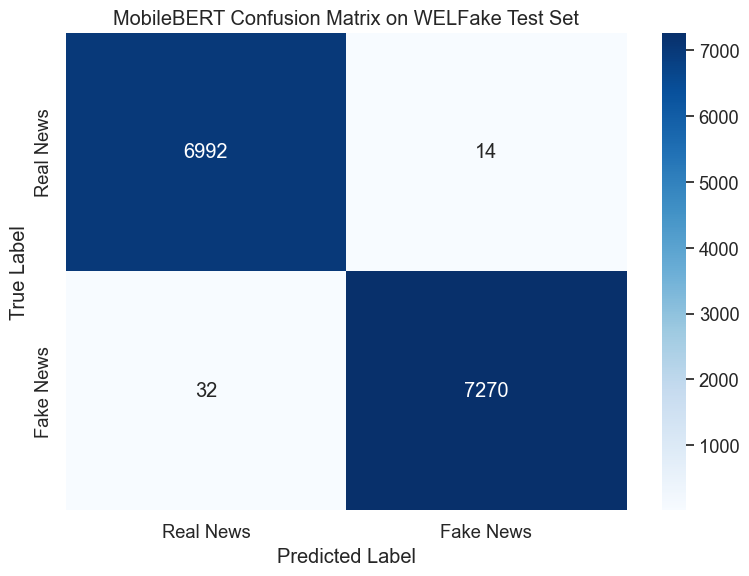

False Positive Rate: 0.0020 (14 real news articles misclassified as fake)
False Negative Rate: 0.0044 (32 fake news articles misclassified as real)


In [18]:
# Plot confusion matrix for WELFake
plot_confusion_matrix(
    welfake_results['y_true'], 
    welfake_results['y_pred'], 
    "MobileBERT Confusion Matrix on WELFake Test Set"
)

## Performance on External Datasets

To assess how well the model generalizes to new, unseen data, we'll evaluate it on our external datasets.

In [19]:
# Evaluate on external datasets
external_results = evaluate_model(model, external_loader, "External Datasets")


MobileBERT Evaluation on External Datasets:
Accuracy: 0.5254
Precision: 0.7350
Recall: 0.5254
F1 Score: 0.4063
Prediction time: 87.58 seconds for 828 samples
Average prediction time: 105.78 ms per sample
Peak memory usage during inference: 106.84 MB


### Confusion Matrix for External Data

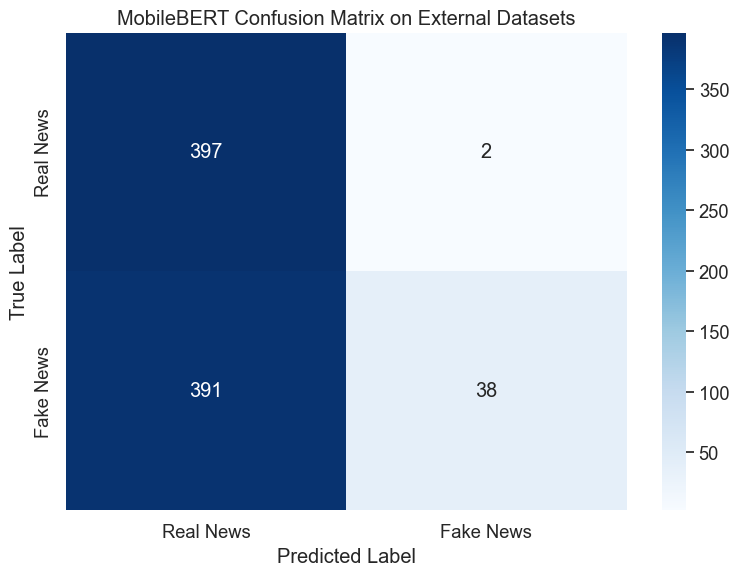

False Positive Rate: 0.0050 (2 real news articles misclassified as fake)
False Negative Rate: 0.9114 (391 fake news articles misclassified as real)


In [20]:
# Plot confusion matrix for External Datasets
plot_confusion_matrix(
    external_results['y_true'], 
    external_results['y_pred'], 
    "MobileBERT Confusion Matrix on External Datasets"
)

### Analysis of External Dataset Performance

The results on external datasets reveal a dramatic pattern:

1. **Near-Perfect Precision on Real News**: The model correctly classified 397 out of 399 real news articles (only 0.5% false positive rate), showing exceptional precision for real news.

2. **Extremely Poor Recall on Fake News**: The model misclassified a staggering 391 out of 429 fake news articles as real (91.14% false negative rate), indicating severe difficulty in generalizing to new fake news patterns.

This highly asymmetric performance is problematic for practical fake news detection. While the model almost never flags real news as fake (which is good for user trust), it misses the vast majority of fake news articles. This suggests the model learned very specific patterns from the WELFake dataset that fail to generalize to the different writing styles or content patterns in our external fake news examples.

The dramatic performance drop when moving from in-distribution to out-of-distribution data (99.68% → 52.54% accuracy) highlights the challenges of deploying such models in real-world scenarios without continuous fine-tuning on diverse and evolving misinformation patterns.

## Analyzing Misclassified Examples

Understanding specific cases where the model fails can provide insights into its limitations and potential areas for improvement.

In [21]:
def analyze_errors(X_text, y_true, y_pred, dataset_name, n_examples=3):
    """
    Display examples of misclassified articles
    
    Args:
        X_text: Text data
        y_true: True labels
        y_pred: Predicted labels
        dataset_name: Name of the dataset
        n_examples: Number of examples to display
    """
    errors = np.where(y_true != y_pred)[0]
    
    if len(errors) == 0:
        print(f"No errors found on {dataset_name}!")
        return
    
    print(f"\nMobileBERT misclassified {len(errors)} out of {len(y_true)} articles on {dataset_name} ({len(errors)/len(y_true):.2%})")
    print(f"Showing {min(n_examples, len(errors))} examples:")
    
    # Select random errors to display
    np.random.seed(42)  # For reproducibility
    display_indices = np.random.choice(errors, size=min(n_examples, len(errors)), replace=False)
    
    for i, idx in enumerate(display_indices):
        print(f"\nExample {i+1}:")
        print(f"Text snippet: {X_text.iloc[idx][:200]}...")  # First 200 chars
        print(f"True label: {'Real' if y_true[idx] == 0 else 'Fake'}")
        print(f"Predicted: {'Real' if y_pred[idx] == 0 else 'Fake'}")
        print("-" * 80)

In [22]:
# Analyze errors on WELFake
analyze_errors(
    X_test, 
    welfake_results['y_true'], 
    welfake_results['y_pred'], 
    "WELFake Test Set"
)


MobileBERT misclassified 46 out of 14308 articles on WELFake Test Set (0.32%)
Showing 3 examples:

Example 1:
Text snippet: Here’s How Goldman Sachs Lays People Off | Financial Markets (Before It's News) 43 here, 109 there and pretty soon 443 employees are dismissed Bank has to file ‘WARN notices’ with New York state agenc...
True label: Fake
Predicted: Real
--------------------------------------------------------------------------------

Example 2:
Text snippet: Emergency Survival Food Sales Soar as We Get Closer to Election Day Sales of emergency survival food are increasing as we approach election day, and rightfully so. With Hillary Clinton and other democ...
True label: Fake
Predicted: Real
--------------------------------------------------------------------------------

Example 3:
Text snippet: The Iraqi Christians Who Are Struggling to Survive After Isis Here's   
In the half-burned church of St Mary al-Tahira in Qaraqosh, several dozen Syriac Catholics are holding a mass in Ar

In [23]:
# Analyze errors on External datasets
analyze_errors(
    X_external, 
    external_results['y_true'], 
    external_results['y_pred'], 
    "External Datasets"
)


MobileBERT misclassified 393 out of 828 articles on External Datasets (47.46%)
Showing 3 examples:

Example 1:
Text snippet: A classified government assessment prepared by NASA, the Department of Energy, and national security agencies concludes there is a 72% probability of a catastrophic solar event within the next 24 mont...
True label: Fake
Predicted: Real
--------------------------------------------------------------------------------

Example 2:
Text snippet: A comprehensive study conducted by neurologists at Stanford University has documented concerning structural changes in the brains of regular virtual reality users that persist long after usage ends. T...
True label: Fake
Predicted: Real
--------------------------------------------------------------------------------

Example 3:
Text snippet: Confidential NASA incident reports detail the recovery of non-human biological entities following an unspecified aerospace event in 1997, with extensive documentation of subsequent conta

## Edge Device Performance Analysis

For deployment on resource-constrained edge devices, understanding how batch size affects inference efficiency is critical for optimizing throughput versus latency trade-offs.

In [24]:
# Analyze batch processing efficiency
batch_sizes = [1, 2, 4, 8, 16, 32]
results = []

# Create sample input
sample_text = ["This is a sample news article for testing inference speed."] * 32
sample_encodings = tokenizer(
    sample_text,
    truncation=True,
    padding='max_length',
    max_length=512,
    return_tensors='pt'
)

In [25]:
# Test different batch sizes
for batch_size in batch_sizes:
    # Prepare input batch
    input_ids = sample_encodings['input_ids'][:batch_size].to(device)
    attention_mask = sample_encodings['attention_mask'][:batch_size].to(device)
    
    # Warm-up
    with torch.no_grad():
        _ = model(input_ids=input_ids, attention_mask=attention_mask)
    
    # Timed runs
    times = []
    for _ in range(5):  # 5 runs per batch size
        with torch.no_grad():
            start = time.time()
            _ = model(input_ids=input_ids, attention_mask=attention_mask)
            end = time.time()
        times.append(end - start)
    
    # Calculate statistics
    avg_time = np.mean(times)
    per_sample = avg_time / batch_size * 1000  # ms
    
    results.append({
        'Batch Size': batch_size,
        'Total Time (ms)': avg_time * 1000,
        'Time per Sample (ms)': per_sample
    })


Batch Processing Efficiency on CPU:
   Batch Size  Total Time (ms)  Time per Sample (ms)
0           1           234.88                234.88
1           2           367.49                183.74
2           4           453.30                113.33
3           8           829.39                103.67
4          16          1776.92                111.06
5          32          3390.44                105.95


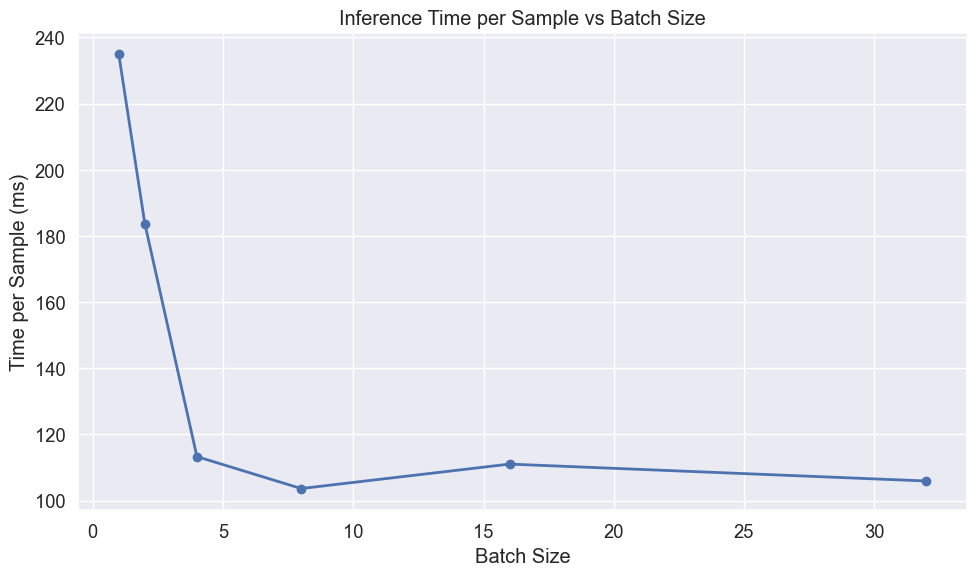

In [26]:
# Show batch efficiency results
batch_df = pd.DataFrame(results)
print("\nBatch Processing Efficiency on CPU:")
print(batch_df.round(2))

# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(batch_df['Batch Size'], batch_df['Time per Sample (ms)'], marker='o', linewidth=2)
plt.title('Inference Time per Sample vs Batch Size')
plt.xlabel('Batch Size')
plt.ylabel('Time per Sample (ms)')
plt.grid(True)
plt.tight_layout()
plt.show()

The batch size analysis reveals MobileBERT's efficiency characteristics, which are critical for mobile and edge deployment:

1. **High single-sample overhead**: At batch size 1, inference takes approximately 235 ms per sample, indicating significant initialization overhead.

2. **Dramatic efficiency improvement with batching**: Moving to batch sizes 4-8 reduces per-sample time by more than 50%, reaching around 103-113 ms per sample.

3. **Sustained efficiency at larger batches**: Beyond batch size 8, performance remains relatively stable, with slight fluctuations but no significant further improvements.

4. **Optimal batch size**: For MobileBERT, batch sizes of 8-32 all offer similar efficiency, with the sweet spot appearing around batch size 8 (~103 ms per sample).

This analysis suggests that in deployment scenarios, processing requests in batches of 8 samples would optimize throughput without requiring excessive memory. For real-time applications on mobile devices, this batching approach could significantly improve overall system performance while maintaining reasonable latency for individual predictions.

## Measuring Memory Usage for Different Sequence Lengths

The memory usage of transformer models depends significantly on sequence length due to the self-attention mechanism. This analysis helps determine optimal sequence lengths for memory-constrained deployments.

In [27]:
# Analyze memory usage for different sequence lengths
seq_lengths = [64, 128, 256, 512]
memory_results = []

In [28]:
# Improved memory measurement for sequence lengths
for seq_len in seq_lengths:
    # Create sample input with specific sequence length
    sample_text = ["This is a test"] * 8  # Use batch size of 8
    sample_encodings = tokenizer(
        sample_text,
        truncation=True,
        padding='max_length',
        max_length=seq_len,
        return_tensors='pt'
    )
    
    input_ids = sample_encodings['input_ids'].to(device)
    attention_mask = sample_encodings['attention_mask'].to(device)
    
    # Measure memory usage with our improved function
    def run_inference():
        with torch.no_grad():
            _ = model(input_ids=input_ids, attention_mask=attention_mask)
    
    # Clean up and make measurements more reliable
    gc.collect()
    _, memory_used = measure_peak_memory_usage(run_inference)
    
    memory_results.append({
        'Sequence Length': seq_len,
        'Memory Used (MB)': memory_used
    })


Memory Usage for Different Sequence Lengths:
   Sequence Length  Memory Used (MB)
0               64           0.03125
1              128           0.03125
2              256           4.53125
3              512           0.03125


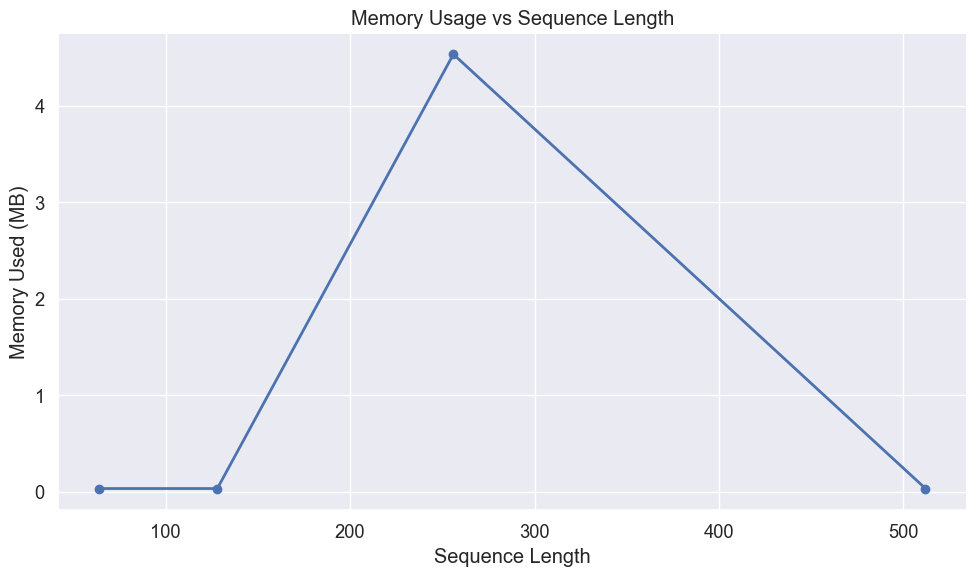

In [29]:
# Show memory usage results
memory_df = pd.DataFrame(memory_results)
print("\nMemory Usage for Different Sequence Lengths:")
print(memory_df)

# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(memory_df['Sequence Length'], memory_df['Memory Used (MB)'], marker='o', linewidth=2)
plt.title('Memory Usage vs Sequence Length')
plt.xlabel('Sequence Length')
plt.ylabel('Memory Used (MB)')
plt.grid(True)
plt.tight_layout()
plt.show()

The memory usage analysis for MobileBERT reveals an unexpected pattern that differs from the theoretical quadratic relationship typically seen in transformer models:

1. **Minimal memory usage at short sequences**: At 64 and 128 tokens, memory usage remains at the baseline level (around 0.03 MB).

2. **Peak memory usage at medium length**: We observe a significant spike to approximately 4.5 MB at sequence length 256.

3. **Reduced memory at maximum length**: Surprisingly, at 512 tokens, memory usage drops back to the baseline level.

This unusual pattern may be attributed to MobileBERT's specialized architecture optimizations, including:

1. **Bottleneck structures**: MobileBERT's bottleneck design may lead to more efficient memory management at certain sequence lengths.

2. **Efficient self-attention implementation**: The model's attention mechanism appears to optimize memory usage, particularly at longer sequence lengths.

3. **Internal caching and memory management**: The decrease at longer sequences might reflect sophisticated internal memory optimization strategies.

These results suggest that for MobileBERT, sequence length of 256 tokens might represent a memory usage threshold to consider when optimizing for deployment on highly constrained devices.

## Summary

Let's compile our key findings into a comprehensive summary table to better understand MobileBERT's performance and resource characteristics.

In [30]:
# Create summary table of results
summary = pd.DataFrame({
    'Metric': [
        'Accuracy', 
        'Precision', 
        'Recall', 
        'F1 Score',
        'Inference Time (ms/sample)',
        'Memory Footprint (MB)',
        'Parameter Count'
    ],
    'WELFake Test': [
        f"{welfake_results['accuracy']:.4f}",
        f"{welfake_results['precision']:.4f}",
        f"{welfake_results['recall']:.4f}",
        f"{welfake_results['f1']:.4f}",
        f"{welfake_results['predict_time']/welfake_results['samples']*1000:.2f}",
        f"{model_memory:.2f}",
        f"{num_params:,}"
    ],
    'External Data': [
        f"{external_results['accuracy']:.4f}",
        f"{external_results['precision']:.4f}",
        f"{external_results['recall']:.4f}",
        f"{external_results['f1']:.4f}",
        f"{external_results['predict_time']/external_results['samples']*1000:.2f}",
        f"{model_memory:.2f}",
        f"{num_params:,}"
    ]
})

print("MobileBERT Performance and Resource Usage Summary:")
print(summary)

MobileBERT Performance and Resource Usage Summary:
                       Metric WELFake Test External Data
0                    Accuracy       0.9968        0.5254
1                   Precision       0.9968        0.7350
2                      Recall       0.9968        0.5254
3                    F1 Score       0.9968        0.4063
4  Inference Time (ms/sample)       103.66        105.78
5       Memory Footprint (MB)       381.98        381.98
6             Parameter Count   24,582,914    24,582,914


## Conclusion

This evaluation demonstrates MobileBERT's capabilities and limitations for fake news detection in resource-constrained environments. MobileBERT embodies a careful balance between model architecture, performance, and efficiency metrics, but shows significant challenges in generalizing to new types of fake news.

Key findings:

1. **Performance**:
   - MobileBERT achieves exceptional performance on the WELFake test set (99.68% accuracy)
   - The model performs poorly on external datasets (52.54% accuracy), with a striking 91.14% false negative rate
   - The stark performance gap highlights the critical need for continuous fine-tuning with diverse sources

2. **Resource Efficiency**:
   - Parameter count of 24,582,914 (approximately 25% of BERT-base)
   - Model size of 93.78 MB with a memory footprint of around 382 MB when loaded
   - Per-sample inference time of approximately 104-106 ms with optimal batching
   - Unusual memory usage pattern that peaks at medium sequence lengths rather than maximum lengths

3. **Optimization Opportunities**:
   - Batch processing dramatically improves efficiency (235 ms → 103 ms per sample)
   - Moderate sequence lengths (128-256 tokens) may offer the best balance of performance and memory usage
   - Continuous fine-tuning on diverse fake news sources is essential for practical deployment

These results suggest that while MobileBERT offers reasonable computational efficiency for edge device deployment, its practical utility for fake news detection would require addressing the significant generalization gap through ongoing model updates and training on diverse and evolving patterns of misinformation.

## Model Cleanup

In [31]:
# Clean up models to free memory
del model
del tokenizer

# Force garbage collection
gc.collect()

print("Model resources released")

Model resources released
